# Line Segment Intersection Exercises

**1.** Implement an algorithm that finds intersection points from the set of line segments $S$ in $O((n+k)logn)$, where $n$ is the number of segments and $k$ is the number of intersection points. 

For starters, we need to define two datastructures that are used in the output-sensitive sweep line algorithm that calculates intersection points: __event queue__ and __status structure__.

Event queue is a balanced binary tree that stores event points of the sweep line algorithm for finding intersection points in the set of line segments $S$. In Python, this will be a Python dictionary with Point2D objects that already has the comparator function implemented.

A status structure is a little trickier for implementation, since it needs to store line segments that crosses the current state of the sweep line. This comparator has to be dependent on the event point to store line segments in order.

First, we need to generate some line segments and test our event queue.

In [1]:
import matplotlib.pyplot as plt
from comgeo.plane import Point2D, DirectedEdge
import random

# number of line segments
N = 7

min_val = 2
max_val = 5

def generate_segments(number_of_segments, min_val, max_val):
    segment_list = list()

    for i in range(number_of_segments):
        x1 = random.random() * (max_val - min_val) + min_val
        y1 = random.random() * (max_val - min_val) + min_val
        x2 = random.random() * (max_val - min_val) + min_val
        y2 = random.random() * (max_val - min_val) + min_val

        begin = Point2D(x1, y1)
        end = Point2D(x2, y2)

        segment_list.append(DirectedEdge(begin, end))
        
    return segment_list
    
def plot_segments(segment_list):
    for segment in segment_list:
        plt.plot([segment.begin.x, segment.end.x], [segment.begin.y, segment.end.y])

We will develop a function that calculates the intersection point of type Point2D if they are intersecting. If they are not, it will return None, since there is no intersection. Let's check the simplest algorithm in $O(n^2)$ for finding segment intersections just we can see later if algorithm computes all the intersection points:

In [2]:
def calculate_intersection(segment_1, segment_2):
    if not segment_1.is_intersecting(segment_2) or segment_1.is_collinear(segment_2):
        # If segments are collinear, we don't cover cases with infinite solutions
        # If segments are not intersecting, we won't calculate them
        return None
    
    x1 = segment_1.begin.x
    y1 = segment_1.begin.y
    
    x2 = segment_1.end.x
    y2 = segment_1.end.y
    
    x3 = segment_2.begin.x
    y3 = segment_2.begin.y
    
    x4 = segment_2.end.x
    y4 = segment_2.end.y
    
    # Slopes
    if x2 - x1 == 0 and x4 - x3 == 0:
        if x1 == x3 or x1 == x4:
            return segment_1.begin
        elif x2 == x3 or x2 == x4:
            return segment_2.end
        
        return None
    elif x2 - x1 == 0:
        m2 = (y4 - y3) / (x4 - x3)
        
        intersection_x = x2
        intersection_y = m2 * (x2 - x3) + y3 
        
        return Point2D(intersection_x, intersection_y)
    
    elif x4 - x3 == 0:
        m1 = (y2 - y1) / (x2 - x1)
        
        intersection_x = x3
        intersection_y = m1 * (x3 - x1) + y1
        
        return Point2D(intersection_x, intersection_y)
    
    m1 = (y2 - y1) / (x2 - x1)
    m2 = (y4 - y3) / (x4 - x3)
    
    # Test if collinear
    if m1 == m2:
        return None
    
    intersection_x = (y3 - y1 + m1 * x1 - m2 * x3) / (m1 - m2)
    intersection_y = m1 * (intersection_x - x1) + y1
    
    return Point2D(intersection_x, intersection_y)

def find_intersection_quadratic(segment_list):
    intersections = set()
    for i in range(len(segment_list)):
        for j in range(i + 1, len(segment_list)):
            intersection = calculate_intersection(segment_list[i], segment_list[j])
            
            if intersection:
                intersections.add(intersection)
            
    return intersections

In [3]:
def scatter_intersections(intersections):
    for intersection in intersections:
        plt.scatter(intersection.x, intersection.y)

14


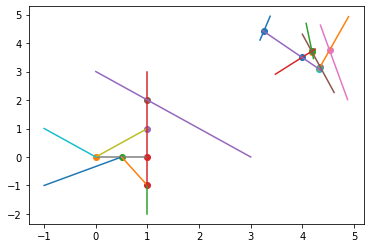

In [4]:
segment_list = generate_segments(N, min_val, max_val)

segment_list.append(DirectedEdge(Point2D(0, 0), Point2D(1, 0)))
segment_list.append(DirectedEdge(Point2D(0, 0), Point2D(1, 1)))
segment_list.append(DirectedEdge(Point2D(0, 0), Point2D(-1, 1)))
segment_list.append(DirectedEdge(Point2D(0.5, 0), Point2D(-1, -1)))
segment_list.append(DirectedEdge(Point2D(0.5, 0), Point2D(1, -1)))
segment_list.append(DirectedEdge(Point2D(1, -1), Point2D(1, -2)))
segment_list.append(DirectedEdge(Point2D(1, -1), Point2D(1, 3)))
segment_list.append(DirectedEdge(Point2D(0, 3), Point2D(3, 0)))

intersections = find_intersection_quadratic(segment_list)

print(len(intersections))

plot_segments(segment_list)
scatter_intersections(intersections)

plt.show()

Now we need to develop an event queue:

In [46]:
def height(nodeBST):
    if nodeBST == None:
        return 0
    return nodeBST.height

class NodeBST():
    def __init__(self, value):
        self.value = value
        self.left = None
        self.right = None
        self.height = 1
        
    def __str__(self):
        return "Node({}, {})".format(self.value, self.height)

class BalancedBST():
    def __init__(self):
        self.root = None
        
    def is_empty(self):
        return False if self.root else True
    
    def __balance(self, root):
        if root == None:
            return None
        
        left_height = height(root.left)
        right_height = height(root.right)
        
        if abs(left_height - right_height) > 1:
            
            if left_height > right_height:
                left_left_height = height(root.left.left)
                left_right_height = height(root.left.right)
                
                if left_left_height > left_right_height:
                    root = self.__rotate_right(root)
                else:
                    root = self.__rotate_left_right(root)
            
            else:
                right_left_height = height(root.right.left)
                right_right_height = height(root.right.right)
                
                if right_right_height > right_left_height:
                    root = self.__rotate_left(root)
                else:
                    root = self.__rotate_right_left(root)
        
        return root
                    
            
    def __rotate_right(self, root):
        temp_left_right = root.left.right
        temp_left = root.left
        
        root.left.right = root
        root.left = temp_left_right
        root = temp_left
        
        root.right.height = max(height(root.right.left), height(root.right.right)) + 1
        root.height = max(height(root.left), height(root.right)) + 1
        
        return root
    
    def __rotate_left(self, root):
        temp_right_left = root.right.left
        temp_right = root.right
        
        root.right.left = root
        root.right = temp_right_left
        root = temp_right
        
        root.left.height = max(height(root.left.left), height(root.left.right)) + 1
        root.height = max(height(root.left), height(root.right)) + 1
        
        return root
    
    def __rotate_left_right(self, root):
        root.left = self.__rotate_left(root.left)
        root = self.__rotate_right(root)
        
        return root
    
    def __rotate_right_left(self, root):
        root.right = self.__rotate_right(root.right)
        root = self.__rotate_left(root)
        
        return root
    
    def __recursive_insert(self, root, value):
        if value <= root.value and root.left:
            root.left = self.__recursive_insert(root.left, value)
        elif value >= root.value and root.right:
            root.right = self.__recursive_insert(root.right, value)
        elif value <= root.value:
            root.left = NodeBST(value)
        else:
            root.right = NodeBST(value)
            
        left_height = height(root.left)
        right_height = height(root.right)
        
        root.height = max(left_height, right_height) + 1
        
        root = self.__balance(root)
        
        return root
        
    def insert(self, value):
        if self.root == None:
            self.root = NodeBST(value)
        else:
            self.root = self.__recursive_insert(self.root, value)
            
    def __recursive_find_min(self, root):
        if root.left:
            return self.__recursive_find_min(root.left)
        else:
            return root.value
    
    def __recursive_delete_node(self, value, root):
        if root == None:
            return None
        
        if(value < root.value):
            root.left = self.__recursive_delete_node(value, root.left)
        elif(root.value < value):
            root.right = self.__recursive_delete_node(value, root.right)
        elif(root.left and root.right):
            root.value = self.__recursive_find_min(root.right)
            root.right = self.__recursive_delete_node(root.value, root.right)
        else:
            old_node = root
            root = root.left if root.left else root.right
            root = self.__balance(root)
            return root
        
        root = self.__balance(root)
        return root
    
    def delete_node_first(self, value):
        root = self.__recursive_delete_node(value, self.root)

        self.root = root
    
    def find_min(self):
        return self.__recursive_find_min(self.root)
    
    def pop_min(self):
        minimum = self.__recursive_find_min(self.root)
        self.root = self.__recursive_delete_node(minimum, self.root)
        
        return minimum
    
    def __recursive_print_preorder(self, root):
        if root:
            print(root)
            self.__recursive_print_preorder(root.left)
            self.__recursive_print_preorder(root.right)
    
    def print_preorder(self):
        self.__recursive_print_preorder(self.root)